In [5]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import pandas as pd

In [10]:
# Main SEIR function
def gillespie_seir(N, beta_func, delta, gamma, mu, initial_infected, initial_exposed, max_time, *beta_args):
    # Initial conditions
    S = N - initial_infected - initial_exposed
    E = initial_exposed
    I = initial_infected
    R = 0
    
    # Arrays to store results
    times = np.zeros(1000000)
    susceptible = np.zeros(1000000)
    susceptible[0] = S
    exposed = np.zeros(1000000)
    exposed[0] = E
    infected = np.zeros(1000000)
    infected[0] = I
    recovered = np.zeros(1000000)
    recovered[0] = R
    
    t = 0
    ind = 0
    beta = beta_func(t, beta_args)
    while t < max_time:
        # Calculate rates (transmission, symptom onset, recovery, birth and deaths)
        beta = beta_func(t, beta_args)
        lambda_SE = beta * S * I / N
        lambda_EI = delta * E
        lambda_IR = gamma * I
        lambda_birth = mu * N
        lambda_death_S = mu * S
        lambda_death_E = mu * E
        lambda_death_I = mu * I
        lambda_death_R = mu * R
        total_rate = (lambda_SE + lambda_EI + lambda_IR + lambda_birth +
                      lambda_death_S + lambda_death_E + lambda_death_I + lambda_death_R)
        
        if total_rate == 0:
            break
        
        # Calculate time step
        dt = np.random.exponential(1 / total_rate)
        t += dt
        ind += 1
        
        # Determine which event occurs
        rand = np.random.rand() * total_rate
        
        # Work out which event had happened
        if rand < lambda_SE:
            S -= 1
            E += 1
        elif rand < lambda_SE + lambda_EI:
            E -= 1
            I += 1
        elif rand < lambda_SE + lambda_EI + lambda_IR:
            I -= 1
            R += 1
        elif rand < lambda_SE + lambda_EI + lambda_IR + lambda_birth:
            S += 1
        else:
            rand_death = rand - (lambda_SE + lambda_EI + lambda_IR + lambda_birth)
            if rand_death < lambda_death_S:
                S -= 1
            elif rand_death < lambda_death_S + lambda_death_E:
                E -= 1
            elif rand_death < lambda_death_S + lambda_death_E + lambda_death_I:
                I -= 1
            else:
                R -= 1
        
        # Append results
        times[ind] = t
        susceptible[ind] = S
        exposed[ind] = E
        infected[ind] = I
        recovered[ind] = R
    
    return times[:ind+1], susceptible[:ind+1], exposed[:ind+1], infected[:ind+1], recovered[:ind+1]

In [11]:
# Four beta(t) functions for the simulations: 
# Constant, increasing gradually, decreasing gradually, step-decrease
def beta_constant(t, beta0):
    return beta0[0]

def beta_increasing(t, *beta_args):
    beta0, p, tau, beta1 = beta_args[0]
    betat = beta0*(1+p*(t-tau)) if t > tau else beta0
    if betat >= beta1:
        return beta1
    else:
        return betat

def beta_decreasing(t, *beta_args):
    beta0, p, tau, beta1 = beta_args[0]
    betat = beta0*(1-p*(t-tau)) if t > tau else beta0
    if betat <= beta1:
        return beta1
    else:
        return betat

def beta_step(t, *beta_args):
    beta0, beta1, tau = beta_args[0]
    return beta0 if t<tau else beta1

$R_0 = \dfrac{\beta\delta}{(\delta+\mu)(\gamma+\mu)}\Rightarrow \beta = \dfrac{R_0(\delta+\mu)(\gamma+\mu)}{\delta}$

In [19]:
# Constant Parameters
N = 1e5  # Total population
delta = 1/5 # Symptom onset rate (1/delta is the infectious)
gamma = 1/10  # Recovery rate (1/gamma is the infectious period)
R_0 = 4 # Basic reproduction number estimated for alpha variant
mu = 0.00003424657  # Birth and death rate
initial_infected = 500
initial_exposed = 0
max_time = 200
beta0 = R_0 * (delta+mu)*(gamma+mu)/delta
num_res = 100
print(beta0)

beta_trans = 1 * (delta+mu)*(gamma+mu)/delta
print(beta_trans)

0.40020550287655116
0.10005137571913779


## Constant sim: $\beta(t)=\beta_0$
## Increasing sim: $\beta(t)=\beta_0*(1+p*(t-\tau))$
## Decreasing sim: $\beta(t)=\beta_0*(1-p*(t-\tau))$
## Step sim: $\beta(t)=\beta_0(1-H(t-\tau))+\beta_1(H(t-\tau))$

In [23]:
# Run simulation
def constant_sim(alg):
    return alg(N, beta_constant, delta, gamma, mu, initial_infected, initial_exposed, max_time, beta0)

runs = [gillespie_seir for i in range(num_res)]

with Pool(12) as pool:
    res = pool.map(constant_sim, runs)

times = np.arange(0,max_time+0.1,0.1)
I_constant = np.zeros((num_res,len(times)))
for i in range(num_res):
    I_constant[i,:] = np.interp(times,res[i][0],res[i][3])/N

# Run simulation
betalow_inc = 0.05
p_inc = (beta0-betalow_inc)/10
tau = 10
def increasing_sim(alg):
    return alg(N, beta_increasing, delta, gamma, mu, initial_infected, initial_exposed, max_time, betalow_inc, p_inc, tau, beta0)

with Pool(12) as pool:
    res_increasing = pool.map(increasing_sim, runs)

times = np.arange(0,max_time+0.1,0.1)
I_increasing = np.zeros((num_res,len(times)))
for i in range(num_res):
    I_increasing[i,:] = np.interp(times,res_increasing[i][0],res_increasing[i][3]) / N

# Run simulation
betalow = 0.05
p_dec = (beta0-betalow)/10
tau = 10
def decreasing_sim(alg):
    return alg(N, beta_decreasing, delta, gamma, mu, initial_infected, initial_exposed, max_time, beta0, p_dec, tau, betalow)

with Pool(12) as pool:
    res_decreasing = pool.map(decreasing_sim, runs)

times = np.arange(0,max_time+0.1,0.1)
I_decreasing = np.zeros((num_res,len(times)))
for i in range(num_res):
    I_decreasing[i,:] = np.interp(times,res_decreasing[i][0],res_decreasing[i][3]) / N


# Run simulation
betalow = 0.05
tau = 30
def step_sim(alg):
    return alg(N, beta_step, delta, gamma, mu, initial_infected, initial_exposed, max_time, beta0, betalow, tau)

with Pool(12) as pool:
    res_step = pool.map(step_sim, runs)

times = np.arange(0,max_time+0.1,0.1)
I_step = np.zeros((num_res,len(times)))
for i in range(num_res):
    I_step[i,:] = np.interp(times,res_step[i][0],res_step[i][3]) / N

In [24]:
df = pd.DataFrame(I_constant).T
stoch_cst = df.sub(df.mean(axis = 1), axis = 'rows')
df_step = pd.DataFrame(I_step).T
stoch_step = df_step.sub(df_step.mean(axis = 1), axis = 'rows')
df_increasing = pd.DataFrame(I_increasing).T
stoch_inc = df_increasing.sub(df_increasing.mean(axis = 1), axis = 'rows')
df_decreasing = pd.DataFrame(I_decreasing).T
stoch_dec = df_decreasing.sub(df_decreasing.mean(axis = 1), axis = 'rows')

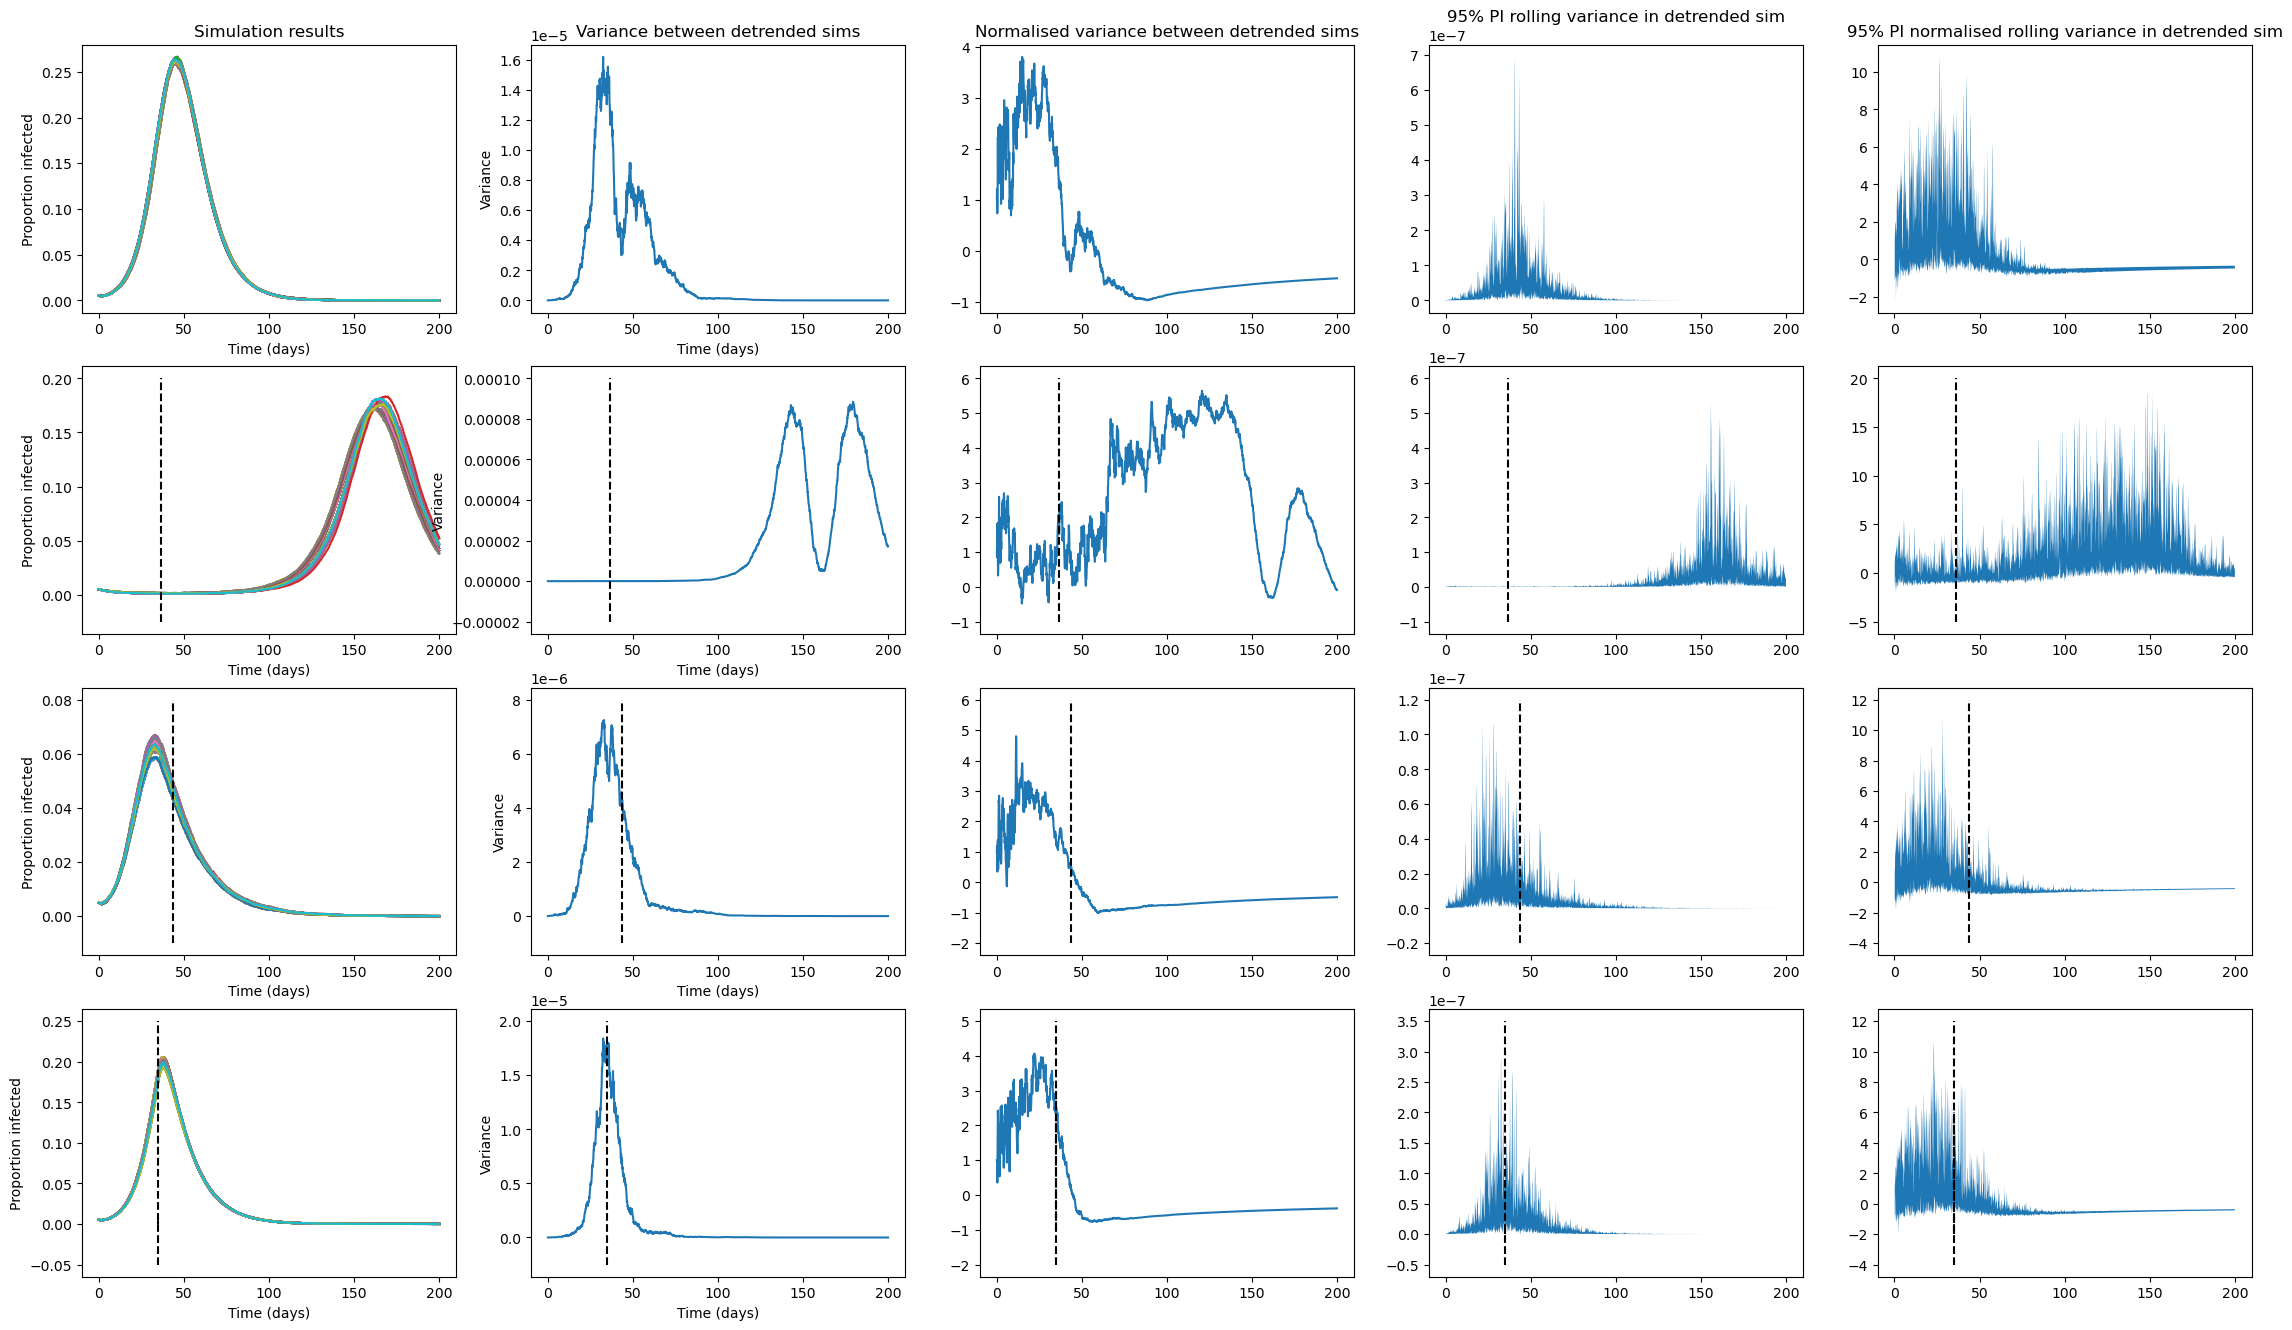

In [35]:
def norm(x):
    rolling_mean = x.expanding().mean()
    rolling_std = x.expanding().std(ddof=0)
    return (x-rolling_mean)/rolling_std

fig, axs = plt.subplots(nrows = 4, ncols = 5, figsize=(28,16))
for i in range(num_res):
    axs[0,0].plot(times,I_constant[i])
axs[0,0].set_xlabel('Time (days)')
axs[0,0].set_ylabel('Proportion infected')
axs[0,1].plot(times,stoch_cst.var(axis=1).values)
axs[0,1].set_xlabel('Time (days)')
axs[0,1].set_ylabel('Variance')

stoch_temp = ((stoch_cst.var(axis=1) - stoch_cst.var(axis=1).expanding().mean())/stoch_cst.var(axis=1).expanding().std(ddof=0))
axs[0,2].plot(times,stoch_temp.values)
stoch_test = stoch_cst.copy(deep=True)
stoch_test['times'] = times
q25 = stoch_test.set_index('times').rolling(7,center=False,min_periods=1).var().quantile(0.05,axis=1)
q75 = stoch_test.set_index('times').rolling(7,center=False,min_periods=1).var().quantile(0.95,axis=1)
axs[0,3].fill_between(times,q25.values,q75.values)
q25 = stoch_test.set_index('times').rolling(7,center=False,min_periods=1).var().apply(norm).quantile(0.05,axis=1)
q75 = stoch_test.set_index('times').rolling(7,center=False,min_periods=1).var().apply(norm).quantile(0.95,axis=1)
axs[0,4].fill_between(times,q25.values,q75.values)

for i in range(num_res):
    axs[1,0].plot(times,I_increasing[i])
axs[1,0].set_xlabel('Time (days)')
axs[1,0].set_ylabel('Proportion infected')
axs[1,1].plot(times,stoch_inc.var(axis=1).values)
axs[1,1].set_xlabel('Time (days)')
axs[1,1].set_ylabel('Variance')
stoch_temp = ((stoch_inc.var(axis=1) - stoch_inc.var(axis=1).expanding().mean())/stoch_inc.var(axis=1).expanding().std(ddof=0))
axs[1,2].plot(times,stoch_temp.values)
stoch_test = stoch_inc.copy(deep=True)
stoch_test['times'] = times
q25 = stoch_test.set_index('times').rolling(7,center=False,min_periods=1).var().quantile(0.05,axis=1)
q75 = stoch_test.set_index('times').rolling(7,center=False,min_periods=1).var().quantile(0.95,axis=1)
axs[1,3].fill_between(times,q25.values,q75.values)
q25 = stoch_test.set_index('times').rolling(7,center=False,min_periods=1).var().apply(norm).quantile(0.05,axis=1)
q75 = stoch_test.set_index('times').rolling(7,center=False,min_periods=1).var().apply(norm).quantile(0.95,axis=1)
axs[1,4].fill_between(times,q25.values,q75.values)
axs[1,0].vlines((beta_trans-betalow_inc) / p_inc + tau,ymin=axs[1,0].get_yticks()[0],ymax=axs[1,0].get_yticks()[-1],color='k',linestyle='--')
axs[1,1].vlines((beta_trans-betalow_inc) / p_inc + tau,ymin=axs[1,1].get_yticks()[0],ymax=axs[1,1].get_yticks()[-1],color='k',linestyle='--')
axs[1,2].vlines((beta_trans-betalow_inc) / p_inc + tau,ymin=axs[1,2].get_yticks()[0],ymax=axs[1,2].get_yticks()[-1],color='k',linestyle='--')
axs[1,3].vlines((beta_trans-betalow_inc) / p_inc + tau,ymin=axs[1,3].get_yticks()[0],ymax=axs[1,3].get_yticks()[-1],color='k',linestyle='--')
axs[1,4].vlines((beta_trans-betalow_inc) / p_inc + tau,ymin=axs[1,4].get_yticks()[0],ymax=axs[1,4].get_yticks()[-1],color='k',linestyle='--')

for i in range(num_res):
    axs[2,0].plot(times,I_decreasing[i])
axs[2,0].set_xlabel('Time (days)')
axs[2,0].set_ylabel('Proportion infected')
axs[2,1].plot(times,stoch_dec.var(axis=1).values)
axs[2,1].set_xlabel('Time (days)')
axs[2,1].set_ylabel('Variance')

stoch_temp = ((stoch_dec.var(axis=1) - stoch_dec.var(axis=1).expanding().mean())/stoch_dec.var(axis=1).expanding().std(ddof=0))
axs[2,2].plot(times,stoch_temp.values)
stoch_test = stoch_dec.copy(deep=True)
stoch_test['times'] = times
q25 = stoch_test.set_index('times').rolling(7,center=False,min_periods=1).var().quantile(0.05,axis=1)
q75 = stoch_test.set_index('times').rolling(7,center=False,min_periods=1).var().quantile(0.95,axis=1)
axs[2,3].fill_between(times,q25.values,q75.values)
q25 = stoch_test.set_index('times').rolling(7,center=False,min_periods=1).var().apply(norm).quantile(0.05,axis=1)
q75 = stoch_test.set_index('times').rolling(7,center=False,min_periods=1).var().apply(norm).quantile(0.95,axis=1)
axs[2,4].fill_between(times,q25.values,q75.values)
axs[2,0].vlines((beta0 - beta_trans) / p_dec + tau,ymin=axs[2,0].get_yticks()[0],ymax=axs[2,0].get_yticks()[-1],color='k',linestyle='--')
axs[2,1].vlines((beta0 - beta_trans) / p_dec + tau,ymin=axs[2,1].get_yticks()[0],ymax=axs[2,1].get_yticks()[-1],color='k',linestyle='--')
axs[2,2].vlines((beta0 - beta_trans) / p_dec + tau,ymin=axs[2,2].get_yticks()[0],ymax=axs[2,2].get_yticks()[-1],color='k',linestyle='--')
axs[2,3].vlines((beta0 - beta_trans) / p_dec + tau,ymin=axs[2,3].get_yticks()[0],ymax=axs[2,3].get_yticks()[-1],color='k',linestyle='--')
axs[2,4].vlines((beta0 - beta_trans) / p_dec + tau,ymin=axs[2,4].get_yticks()[0],ymax=axs[2,4].get_yticks()[-1],color='k',linestyle='--')

for i in range(num_res):
    axs[3,0].plot(times,I_step[i])
axs[3,0].set_xlabel('Time (days)')
axs[3,0].set_ylabel('Proportion infected')
axs[3,1].plot(times,stoch_step.var(axis=1).values)
axs[3,1].set_xlabel('Time (days)')
axs[3,1].set_ylabel('Variance')
axs[3,0].vlines(tau,ymin=0,ymax=0.0035,color='k',linestyle='--')
axs[3,1].vlines(tau,ymin=0,ymax=1.1e-7,color='k',linestyle='--')
axs[3,2].vlines(tau,ymin=-1,ymax=3,color='k',linestyle='--')
axs[3,3].vlines(tau,ymin=0,ymax=6e-9,color='k',linestyle='--')
axs[3,4].vlines(tau,ymin=-2,ymax=6,color='k',linestyle='--')

stoch_temp = ((stoch_step.var(axis=1) - stoch_step.var(axis=1).expanding().mean())/stoch_step.var(axis=1).expanding().std(ddof=0))
axs[3,2].plot(times,stoch_temp.values)
stoch_test = stoch_step.copy(deep=True)
stoch_test['times'] = times
q25 = stoch_test.set_index('times').rolling(7,center=False,min_periods=1).var().quantile(0.05,axis=1)
q75 = stoch_test.set_index('times').rolling(7,center=False,min_periods=1).var().quantile(0.95,axis=1)
axs[3,3].fill_between(times,q25.values,q75.values)
q25 = stoch_test.set_index('times').rolling(7,center=False,min_periods=1).var().apply(norm).quantile(0.05,axis=1)
q75 = stoch_test.set_index('times').rolling(7,center=False,min_periods=1).var().apply(norm).quantile(0.95,axis=1)
axs[3,4].fill_between(times,q25.values,q75.values)

axs[3,0].vlines(tau,ymin=axs[3,0].get_yticks()[0],ymax=axs[3,0].get_yticks()[-1],color='k',linestyle='--')
axs[3,1].vlines(tau,ymin=axs[3,1].get_yticks()[0],ymax=axs[3,1].get_yticks()[-1],color='k',linestyle='--')
axs[3,2].vlines(tau,ymin=axs[3,2].get_yticks()[0],ymax=axs[3,2].get_yticks()[-1],color='k',linestyle='--')
axs[3,3].vlines(tau,ymin=axs[3,3].get_yticks()[0],ymax=axs[3,3].get_yticks()[-1],color='k',linestyle='--')
axs[3,4].vlines(tau,ymin=axs[3,4].get_yticks()[0],ymax=axs[3,4].get_yticks()[-1],color='k',linestyle='--')

axs[0,0].set_title('Simulation results')
axs[0,1].set_title('Variance between detrended sims')
axs[0,2].set_title('Normalised variance between detrended sims')
axs[0,3].set_title('95% PI rolling variance in detrended sim')
axs[0,4].set_title('95% PI normalised rolling variance in detrended sim')

plt.show()